# Pedestal parameters scatter plot generator

Plots the extracted pedestal parameters as a function of ELM phase, ELM time, ST phase, and ST time.

In [36]:
# Author: Magne Lauritzen, mag.lauritzen@gmail.com
# -- use this line at the beginning of your notebook to turn on interactive plots
%matplotlib notebook

# Imports
import statsmodels
import sys
import matplotlib.pyplot as plt  # plotting library
from matplotlib import colors
import numpy as np  # work with numeric arrays without labeled axes
import xarray as xr  # work with arrays with labeled axes
import xrscipy.signal as dsp  # xarray signal filtering etc.
import scipy as sps
from cdb_extras import xarray_support as cdbxr  # access to COMPASS Database (CDB)
import pickle # to save data
from pathlib import Path # to easily work with different files
from progressbar import ProgressBar
plt.rcParams.update({'font.size': 14})

# Import DataClass for condensed pedestal data
%run ./functions.ipynb

In [37]:
# Collect all the extracted pedestal parameters from the /pedestal_data folder
pedestal_data_folder = Path('./pedestal_data')
pedestal_data_list = []

for item in pedestal_data_folder.iterdir():
    if item.is_file and item.suffix == ".bin":
        with open(item, 'rb') as fp:
            pedestal_data_list.append(pickle.load(fp))

In [38]:
# Define some functions for generating plots with a specific style.
def _get_plot():
    fig, ax = plt.subplots(figsize=(6.5,5.5))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xlabel('time [ms]')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    return fig, ax

def _add_legend(ax):
    ax.legend(loc="upper right", fontsize="12")

In [39]:
# Define functions for calculating the ELM lengths and ELM times
def get_elm_length_and_time(shot_nr: int, times: np.ndarray):
    shot = cdbxr.Shot(shot_nr)
    t_ELM_start = shot['t_ELM_start']
    idx = np.searchsorted(t_ELM_start.data, times)
    no_search_result_map = idx == len(t_ELM_start.data)
    idx[no_search_result_map] = 1
    elm_times = times - t_ELM_start.data[idx-1]
    elm_periods = t_ELM_start.data[idx] - t_ELM_start.data[idx-1]
    elm_periods[no_search_result_map] = np.nan
    
    return elm_periods, elm_times

# Define function for getting the ST phase, ELM durations, ST amplitudes, and ST times of each ELM 
def get_ELM_ST_phase_and_duration(shot_nr: int):
    shot = cdbxr.Shot(shot_nr)
    t_ELM_start = shot['t_ELM_start']
    ELM_duration = np.diff(t_ELM_start)
    
    ELM_ST_phase, ELM_ST_time, ST_amplitudes = ST_time_and_phase(shot_nr, t_ELM_start[1:])
    return ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time 

In [40]:
def scatter_pedestal_params(x: str = 'ELM_phase', s: str = 'pe', p: str = 'grad'):
    """
    Creates a scatterplot of one pedestal parameter (grad, height, width) of a Thomson Scatter variable (pe, Te, ne) as 
    a function of either ELM or ST phase or time (ELM_phase, ELM_time, ST_phase, ST_time).
    """
    max_data = 0
    fig, ax = _get_plot()
    
    all_x = np.empty(0)
    for i, d in enumerate(pedestal_data_list):
        time = getattr(d, s+'_time')
        data = getattr(d, s+'_'+p)
        data_err = getattr(d, s+'_'+p+'_err')
        
        mask = time < 1200

        if x == 'ELM_phase':
            x_values = getattr(d, s+'_'+x)
            x_values = x_values[0]
        if x == 'ELM_time':
            _, x_values = get_elm_length_and_time(d.shot_number, time)
            valid_elm_lengths = np.logical_and(0 < x_values, x_values < 20)
            mask = np.logical_and(valid_elm_lengths, mask)
        else:
            x_values = getattr(d, s+'_'+x)
            
        # Plot
        ax.errorbar(x_values[mask], data[mask], data_err[mask], 
                     c='red', ls='None', marker='d', label=f"{d.shot_number}", markersize=6, alpha=0.5)
        
        if np.nanmax(data[mask]) > max_data:
            max_data = np.nanmax(data[mask])
        all_x = np.concatenate((all_x, x_values[mask]))
            
    ax.set_ylabel(s+'_'+p)
    ax.set_xlabel(x)
    ax.set_ylim((0, max_data))
    if x == 'ELM_time':
        ax.set_xlim((0, np.percentile(all_x, 95)))
    ax.set_title("TS pedestal parameters")

<IPython.core.display.Javascript object>


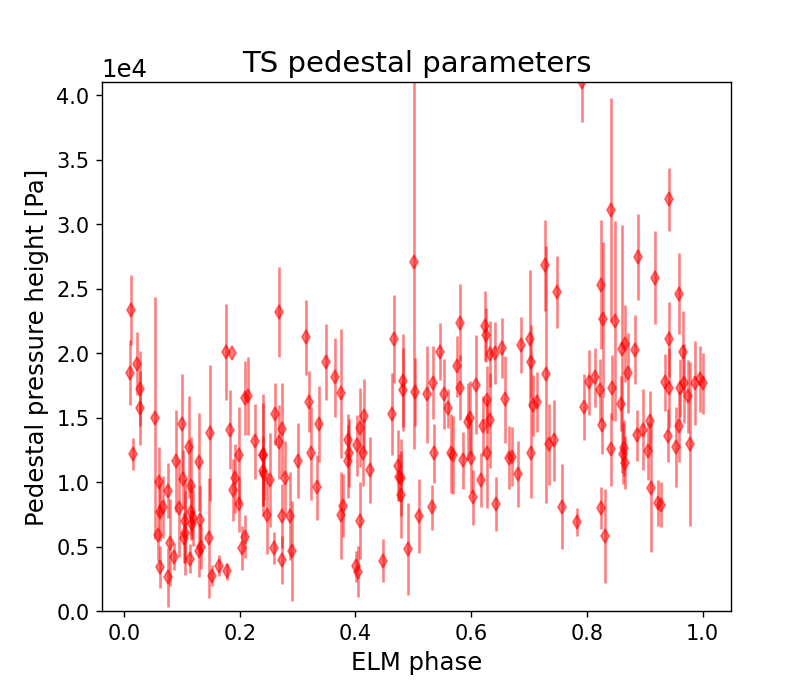

<IPython.core.display.Javascript object>


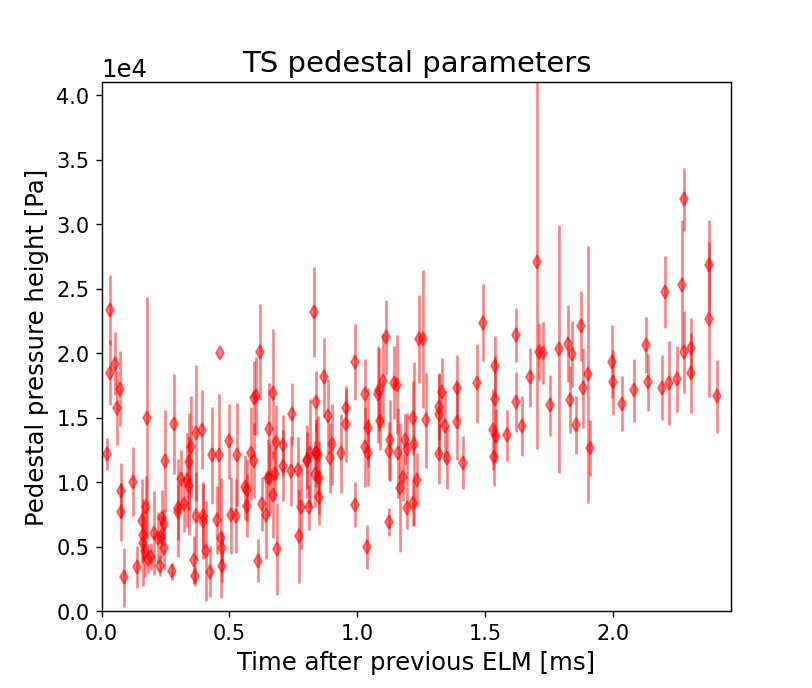

<IPython.core.display.Javascript object>


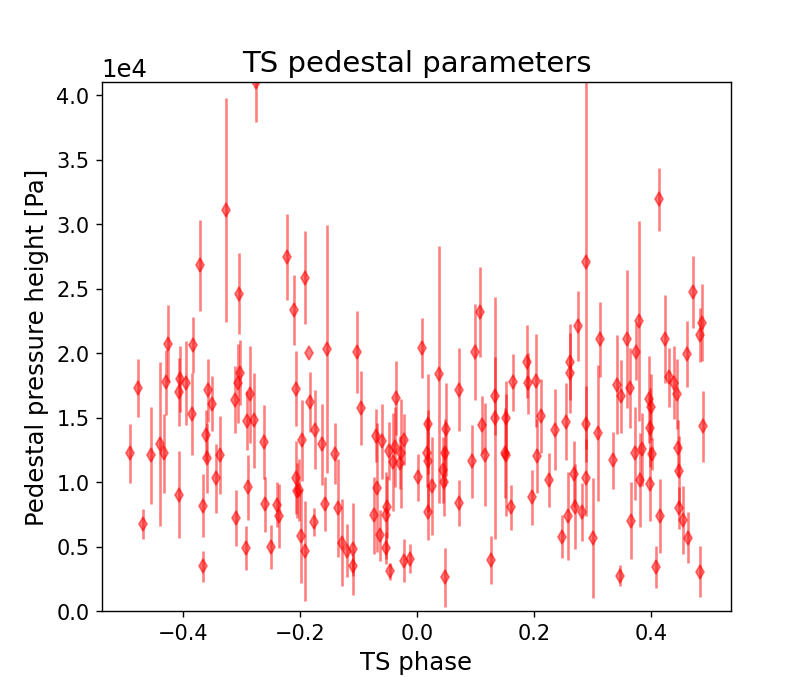

<IPython.core.display.Javascript object>


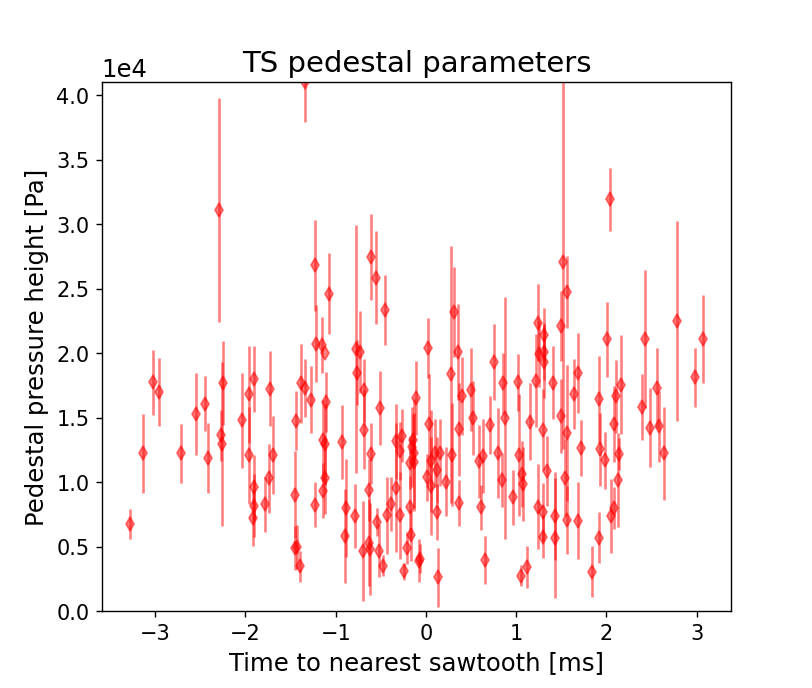

Text(0, 0.5, 'Pedestal pressure height [Pa]')

In [41]:
variable = 'pe' # One of 'pe', 'Te', 'ne'
parameter = 'grad' # One of 'grad', 'height', 'width'

# Generate plots
scatter_pedestal_params(x='ELM_phase', s=variable, p=parameter)
plt.xlabel('ELM phase')
plt.ylabel('Pedestal pressure height [Pa]')

scatter_pedestal_params(x='ELM_time', s=variable, p=parameter)
plt.xlabel('Time after previous ELM [ms]')
plt.ylabel('Pedestal pressure height [Pa]')

scatter_pedestal_params(x='ST_phase', s=variable, p=parameter)
plt.xlabel('TS phase')
plt.ylabel('Pedestal pressure height [Pa]')

scatter_pedestal_params(x='ST_time', s=variable, p=parameter)
plt.xlabel('Time to nearest sawtooth [ms]')
plt.ylabel('Pedestal pressure height [Pa]')